#  Series temporales. Modelos de Suavizado exponencial y ARIMA

En este documento exploramos distintos modelos de suavizado y ARIMA para series univariantes. Este código servirá para los días 5 y 6 ya que resulta cómodo e ilustrativo aplicar todos los métodos a cada conjunto de datos y poder comparar los resultados. 

La idea será buscar los mejores modelos para la predicción de series temporales para los datos que nos lleguen.

# Series temporales I. Suavizado

En esta primera sesión vamos a explorar los métodos de inspección descriptiva de una serie temporal y, posteriormente, los primeros modelos predictivos basados en suavizado exponencial. 

El esquema de trabajo será: 

1. Leer valores de la serie y convertir a formato legible por python
2. Representar la serie para intuir componentes presentes
3. Descomposición de la serie y contraste de estacionariedad
4. Creación de partición en ventanas training/test
5. Aplicación de modelos de suavizado y evaluación de ajuste
6. Aplicación de modelos Arima y evaluación de ajuste

Con esto tendremos una primera aproximación para la predicción de datos a futuro en una serie temporal univariante.


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# pip install r2py 
from rpy2.robjects.packages import importr, data
  
datasets = importr('datasets')
AirPassengers = pd.Series(data(datasets).fetch('AirPassengers')['AirPassengers'])
AirPassengers


0      112.0
1      118.0
2      132.0
3      129.0
4      121.0
       ...  
139    606.0
140    508.0
141    461.0
142    390.0
143    432.0
Length: 144, dtype: float64

Asignamos manualmente la fecha de inicio a fin en intervalos mensuales ya que esta lectura no devuelve las fechas correctamente.. (tenemos de todas formas el csv en la carpeta por si lo necesitáramos). Con date_range generamos las fechas.



In [2]:
fechas = pd.date_range('1949-01-01','1960-12-01', 
               freq='MS').strftime("%Y-%m").tolist()
fechas = pd.Series(fechas)
fechas

0      1949-01
1      1949-02
2      1949-03
3      1949-04
4      1949-05
        ...   
139    1960-08
140    1960-09
141    1960-10
142    1960-11
143    1960-12
Length: 144, dtype: object

Unimos las fechas a los valores de la serie.



In [3]:
# Unir en un data
Air_R = pd.concat([fechas,AirPassengers], axis=1)
Air_R.columns = ['Month','Passengers']
Air_R.head()

Month  Passengers
0  1949-01       112.0
1  1949-02       118.0
2  1949-03       132.0
3  1949-04       129.0
4  1949-05       121.0

Check! 

**Nota**: Esto solo funcionará si sois usuarias de R, es decir, tenéis instalado el software R en vuestro pc. De lo contrario obtendréis un error! Siempre podéis comentar estas líneas, realmente tenemos el archivo en csv y es más cómodo. 

La lectura para gente no usuaria de R sería la siguiente. 


In [4]:
# Lo leemos desde el csv que desde R en el propio R colapsa el espacio-tiempo jeje
Air = pd.read_csv('AirPassengers.csv')
Air.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


Convertimos a serie temporal para que python entienda con una simple asignación de la variable de fecha 'Month' en formato datetime por si acaso. 



In [5]:
# Convertir en serie temporal
Air.set_index(['Month'],inplace=True)
Air.index=pd.to_datetime(Air.index)


A ver cuál es el aspecto.. 



In [6]:
Air



Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

[144 rows x 1 columns]

Ya tenemos la serie preparada para analizar. En primer luegar haremos un estudio descriptivo, pintar, descomponer, entender las componentes y tal vez echar un vistazo a los correlogramas y tests de estacionariedad para los residuos de la descomposición "inocente" con la simple extracción de componentes. 

## Estudio descriptivo

Aquí opción gráfica para que los plot() salgan grandes. 


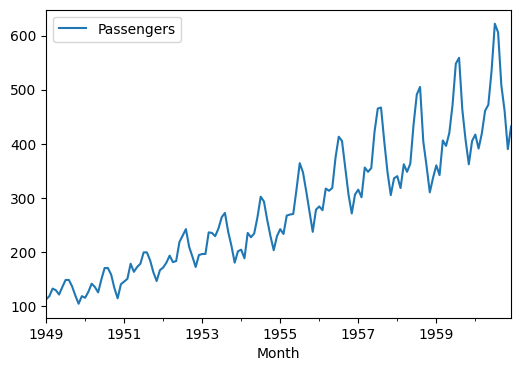

In [7]:
plt.rcParams["figure.figsize"] = (6,4)
Air.plot()
plt.show()


Podemos definir una función que calcule el test de Dickey Fuller para la estacionariedad de la serie. De esta forma, en cualquier momento, introduciendo el vector de valores de la serie, obtendremos el contraste de hipótesis. 

H0: La serie NO es estacionaria
H1: La serie es estacionaria

Por tanto, nos interesará que el contraste de hipótesis sea rechazado (p-valor < 0.05). 


In [8]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', regression ='ct')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


Probamos con la serie al natural. 



In [9]:
test_stationarity(Air)



Results of Dickey-Fuller Test:
Test Statistic                  -2.100782
p-value                          0.545659
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -4.030152
Critical Value (5%)             -3.444818
Critical Value (10%)            -3.147182
dtype: float64


### Descomposición de la serie

En base a la descomposición descriptiva por medias móviles, se extraen las componentes de tendencia y estacionalidad.

**Descomposición aditiva** 


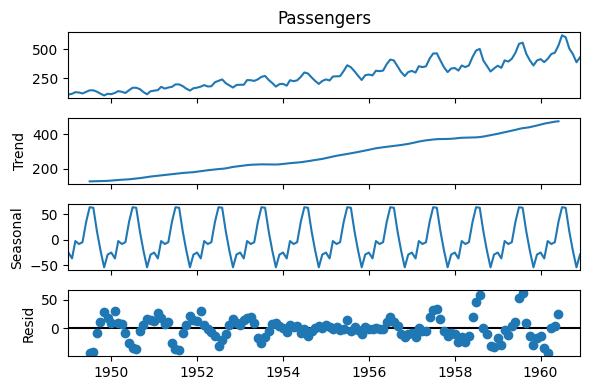

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Aplicar descomposición aditiva
Air_desc_Ad = seasonal_decompose(Air['Passengers'], model='additive',period=12)
Air_desc_Ad.plot()
plt.show()


In [11]:
Air_desc_Ad.seasonal

Month
1949-01-01   -24.748737
1949-02-01   -36.188131
1949-03-01    -2.241162
1949-04-01    -8.036616
1949-05-01    -4.506313
                ...    
1960-08-01    62.823232
1960-09-01    16.520202
1960-10-01   -20.642677
1960-11-01   -53.593434
1960-12-01   -28.619949
Name: seasonal, Length: 144, dtype: float64

Evaluamos estacionariedad de los residuos de la descomposición aditiva. Aquí, debido a que la tendencia se calcula por medias móviles, los primeros y últimos valores de la serie son NA, no se calculan. Simplemente saber esto y tener en cuenta solamente los residuos válidos. 



In [12]:
test_stationarity(Air_desc_Ad.resid.dropna())



Results of Dickey-Fuller Test:
Test Statistic                  -5.279797
p-value                          0.000062
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -4.037614
Critical Value (5%)             -3.448373
Critical Value (10%)            -3.149257
dtype: float64


**Descomposición multiplicativa** 



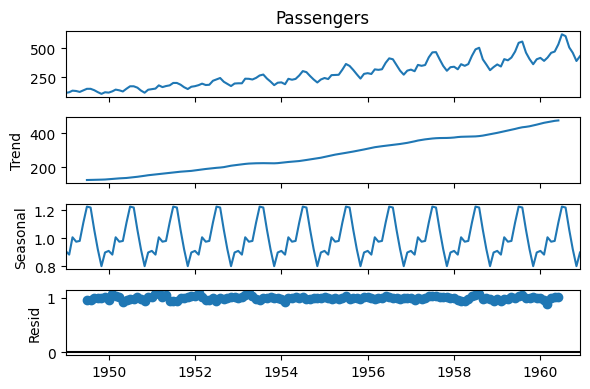

In [13]:
# Aplicar descomposición aditiva
Air_desc_Mul = seasonal_decompose(Air['Passengers'], model='multiplicative')
Air_desc_Mul.plot()
plt.show()


Evaluamos estacionariedad de los residuos de la descomposición Multiplicativa. 



In [14]:
test_stationarity(Air_desc_Mul.resid.dropna())



Results of Dickey-Fuller Test:
Test Statistic                  -6.057240
p-value                          0.000002
#Lags Used                       9.000000
Number of Observations Used    122.000000
Critical Value (1%)             -4.034960
Critical Value (5%)             -3.447109
Critical Value (10%)            -3.148519
dtype: float64


In [15]:
def seasonal_plot(df, season='year', index='month', column=None):
    """Makes a seasonal plot of one column of the input dataframe. Considers the first columns by default.
    
    Arguments:
    
    - df (Pandas DataFrame): DataFrame indexed by Datetime (see `parse_dates` parameter when reading a CSV);
    - season (string): the season that you want to considering when doing the plot, e.g., year, month, etc.;
    - index (string): corresponds to the X axis of the plot. You should choose based on the index period that you're using;
    - column (string, optional): the DataFrame column to consider. Picks the first one by default.
    """
    if column == None:
        column = df.columns[0]
        
    piv_index = getattr(df.index, index)
    piv_season = getattr(df.index, season)
    
    piv = pd.pivot_table(df, index=piv_index, columns=piv_season, values=[column])
    piv.plot(figsize=(12,8))


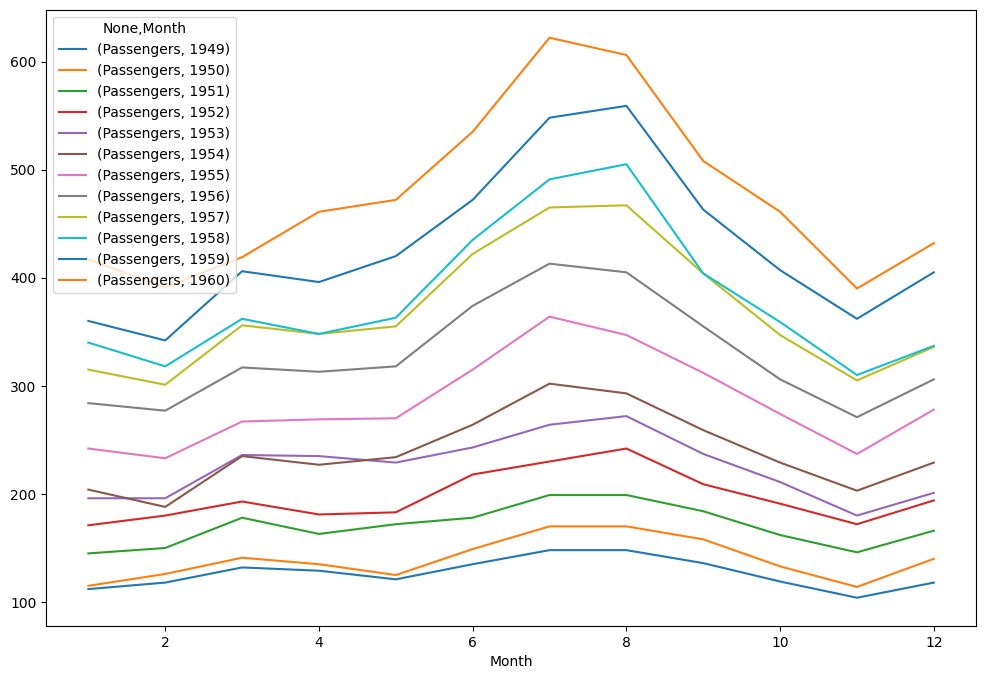

In [16]:
seasonal_plot(Air)
plt.show()


### Hacia la estacionariedad

En esta sección vamos a extraer las componentes identificadas para generar una serie residual y comprobar si es estacionaria una vez eliminados los efectos típicos de las series temporales. 

El esquema es: 

1. Estabilización de la varianza. Transformación Logaritmica
2. Diferenciación regular
3. Diferenciación estacional

Con la serie resultante, comprobaremos estacionariedad y será con la que podemos valorar autocorrelaciones simples y parciales para proponer órdenes ARIMA tentativos par la serie.

#### Estabilización de la varianza. Transformación Logaritmica


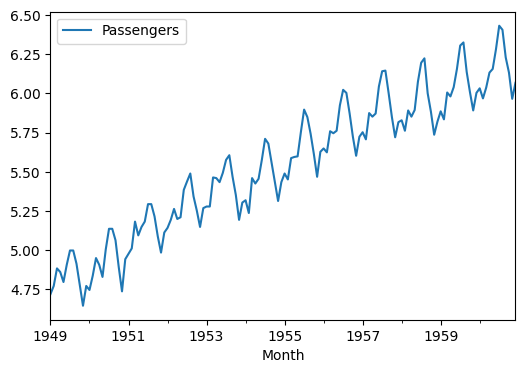

In [17]:
AirLog = np.log(Air)
AirLog.plot()
plt.show()


#### Diferenciación regular



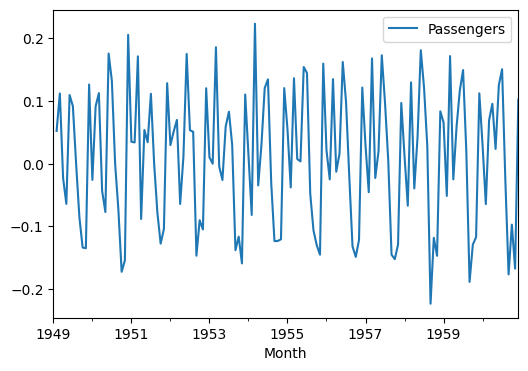

In [18]:
AirLog_diff_1 = AirLog.diff(periods=1)
AirLog_diff_1.plot()
plt.show()


#### Diferenciación estacional



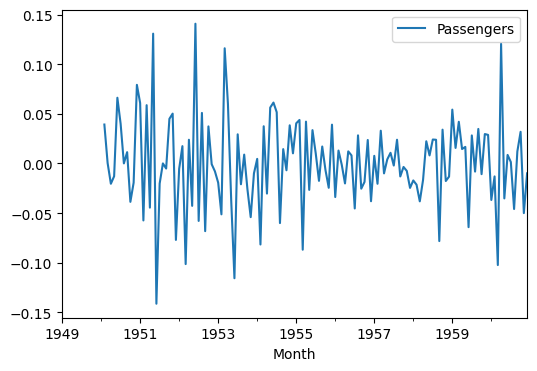

In [19]:
AirLog_diff_1_12 = AirLog_diff_1.diff(periods=12)
AirLog_diff_1_12.plot()
plt.show()


#### Comprobación de estacionariedad



In [20]:
test_stationarity(AirLog_diff_1_12.dropna(inplace=False))



Results of Dickey-Fuller Test:
Test Statistic                  -4.413001
p-value                          0.002087
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -4.037614
Critical Value (5%)             -3.448373
Critical Value (10%)            -3.149257
dtype: float64


#### Autocorrelaciones 



In [21]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


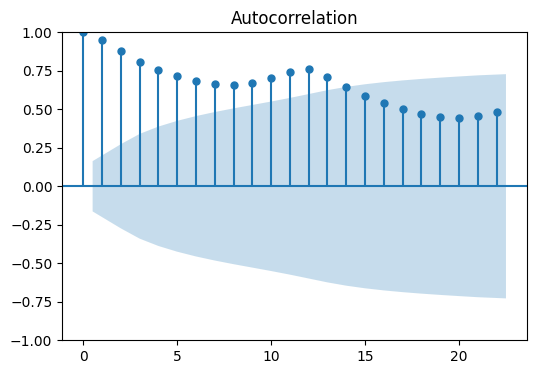

In [22]:
plot_acf(Air)#.dropna(inplace=False))
plt.show()


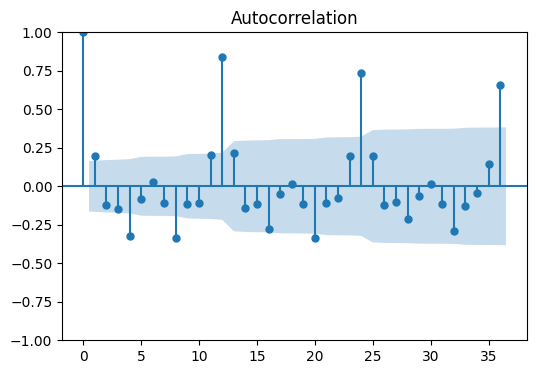

In [23]:
plot_acf(AirLog_diff_1.dropna(inplace=False),lags=36)
plt.show()


In [24]:
AirLog_diff_1_12

Passengers
Month                 
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01   -0.045934
1960-09-01    0.012024
1960-10-01    0.031830
1960-11-01   -0.050082
1960-12-01   -0.009964

[144 rows x 1 columns]

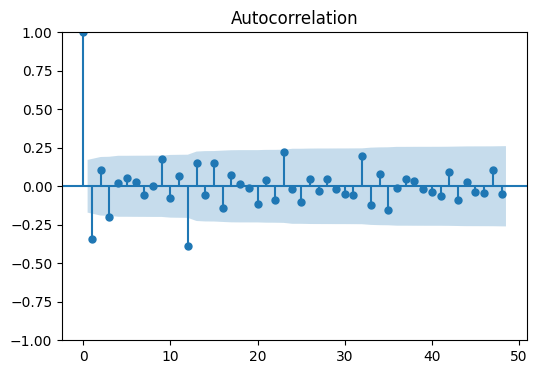

In [25]:
plot_acf(AirLog_diff_1_12.dropna(inplace=False), lags=48)
plt.show()


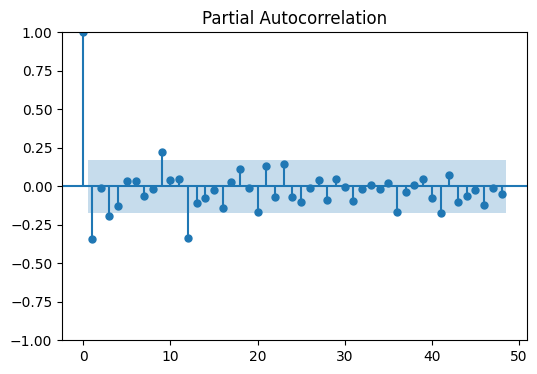

In [26]:
plot_pacf(AirLog_diff_1_12.dropna(inplace=False), lags=48,method='ywm')
plt.show()

In [27]:
# Tets Ljung-box
sm.stats.acorr_ljungbox(AirLog_diff_1_12.dropna(inplace=False), lags=12, return_df=True)


lb_stat     lb_pvalue
1   15.595655  7.843461e-05
2   17.086040  1.949008e-04
3   22.647794  4.781777e-05
4   22.710382  1.446614e-04
5   23.138684  3.175679e-04
6   23.270941  7.106307e-04
7   23.704967  1.283650e-03
8   23.705049  2.567712e-03
9   28.147330  9.012662e-04
10  28.986885  1.252151e-03
11  29.588746  1.837982e-03
12  51.472840  7.685466e-07

In [28]:
sm.stats.acorr_ljungbox(Air, lags=12, return_df=True)



lb_stat      lb_pvalue
1    132.141539   1.393231e-30
2    245.646160   4.556318e-54
3    342.674826   5.751088e-74
4    427.738684   2.817731e-91
5    504.796570  7.360195e-107
6    575.601854  4.264008e-121
7    643.038593  1.305463e-134
8    709.484498  6.496271e-148
9    779.591231  5.249370e-162
10   857.068639  1.100789e-177
11   944.390318  1.766396e-195
12  1036.481907  2.682212e-214

## Modelos de suavizado

Exploramos ahora los distintos métodos de suavizado estudiados sobre la serie de pasajeros de avión. Antes de nada, tomamos las ventanas de training y test para ajuste y evaluación del modelo, respectivamente. 


In [29]:
import statsmodels.tsa.holtwinters as ets
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Generamos la serie logaritmica
AirLog = Air.copy()
AirLog['Passengers'] = np.log(AirLog['Passengers'])
AirLog


Air_tr = AirLog[:'1958-12-01']
Air_tst = AirLog['1959-01-01':]
Air_tst

Passengers
Month                 
1959-01-01    5.886104
1959-02-01    5.834811
1959-03-01    6.006353
1959-04-01    5.981414
1959-05-01    6.040255
1959-06-01    6.156979
1959-07-01    6.306275
1959-08-01    6.326149
1959-09-01    6.137727
1959-10-01    6.008813
1959-11-01    5.891644
1959-12-01    6.003887
1960-01-01    6.033086
1960-02-01    5.968708
1960-03-01    6.037871
1960-04-01    6.133398
1960-05-01    6.156979
1960-06-01    6.282267
1960-07-01    6.432940
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426

Definimos aquí una función para evaluar un modelo (será válido para modelos de suavizado y arima de statsmodels pero no para auto_arima...distintos valores de salida y ajustaremos luego la función para ello)



In [30]:
#forecast_accuracy(fc, test.values)

# Función para evaluar modelo
def eval_model(model,tr,tst,name='Model',lags=12,serie='serie'):
    lb = np.mean(sm.stats.acorr_ljungbox(model.resid, lags=lags, return_df=True).lb_pvalue)
    pred = model.forecast(steps=len(tst))
    fig1, ax = plt.subplots()
    ax.plot(tr, label='training')
    ax.plot(tst, label='test')
    ax.plot(pred, label='prediction')
    plt.legend(loc='upper left')
    tit = name + ":  LjungBox p-value --> " + str(lb) + "\n MAPE: " + str(round(mean_absolute_percentage_error(tst, pred)*100,2)) + "%"
    plt.title(tit)
    plt.ylabel(serie)
    plt.xlabel('Date')
    plt.show()
    print(lb)
 


#### Suavizado Simple

Suavizado simple, ya sabemos que no va a ajustar bien pues es para series sin tendencia y estacionalidad. Solo por ver como ajustarlo en caso de necesidad. Esperamos predicciones constantes para la ventana de test. 


In [31]:
ses = ets.SimpleExpSmoothing(Air_tr).fit()

ses.summary()

C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                       SimpleExpSmoothing Model Results                       
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  120
Model:             SimpleExpSmoothing   SSE                              1.332
Optimized:                       True   AIC                           -536.073
Trend:                           None   BIC                           -530.498
Seasonal:                        None   AICC                          -535.725
Seasonal Periods:                None   Date:                mi., 11 dic. 2024
Box-Cox:                        False   Time:                         14:39:22
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
initial_level              4.7184989                  l.0                False
------------------------------------------------------------------------------
"""

Evaluación del modelo SES.



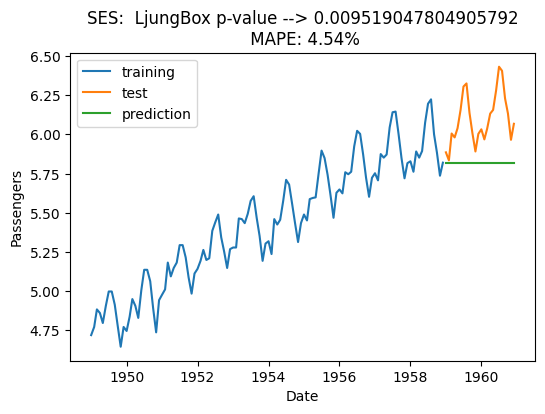

0.009519047804905792


In [32]:
# Evaluar SES
eval_model(ses,Air_tr,Air_tst,'SES',serie='Passengers')


#### Suavizado doble de Holt

Suavizado doble de Holt, con pendiente pero sin componente estacional. Esperamos una recta con pendiente como predicción.


                              Holt Model Results                              
Dep. Variable:             Passengers   No. Observations:                  120
Model:                           Holt   SSE                              1.386
Optimized:                       True   AIC                           -527.298
Trend:                       Additive   BIC                           -516.148
Seasonal:                        None   AICC                          -526.555
Seasonal Periods:                None   Date:                mi., 11 dic. 2024
Box-Cox:                        False   Time:                         14:39:23
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_trend            0.0272976                

C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


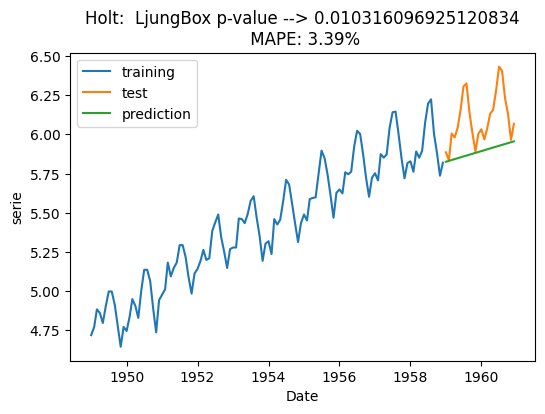

0.010316096925120834


In [33]:
# Suavizado de Holt
holt = ets.Holt(Air_tr).fit()
print(holt.summary())

eval_model(holt,Air_tr,Air_tst,'Holt')


#### Suavizado de Holt Winters Aditivo

Ahora si, vamos a los métodos que podrían funcionar sobre esta serie. En primer lugar, Holt Winters aditivo. Con el aspecto de la serie y la clara heterocedasticidad, no parece que sea la mejor opción...pero probad con el logaritmo veréis que cambio. 


                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                  120
Model:             ExponentialSmoothing   SSE                              0.151
Optimized:                         True   AIC                           -769.603
Trend:                         Additive   BIC                           -725.003
Seasonal:                      Additive   AICC                          -762.831
Seasonal Periods:                    12   Date:                mi., 11 dic. 2024
Box-Cox:                          False   Time:                         14:39:23
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend          

C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


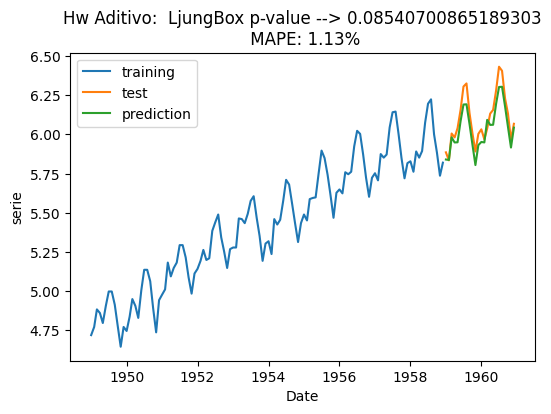

0.08540700865189303


In [34]:
hw_add = ets.ExponentialSmoothing(Air_tr,trend='add', damped_trend=False, seasonal='add').fit()
print(hw_add.summary())

eval_model(hw_add,Air_tr,Air_tst,'Hw Aditivo')


#### Suavizado de Holt Winters Multiplicativo

Suavizado multiplicativo para captar la componente estacional no constante con el tiempo. 


                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                  120
Model:             ExponentialSmoothing   SSE                              0.148
Optimized:                         True   AIC                           -771.706
Trend:                         Additive   BIC                           -727.106
Seasonal:                Multiplicative   AICC                          -764.934
Seasonal Periods:                    12   Date:                mi., 11 dic. 2024
Box-Cox:                          False   Time:                         14:39:24
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend          

C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


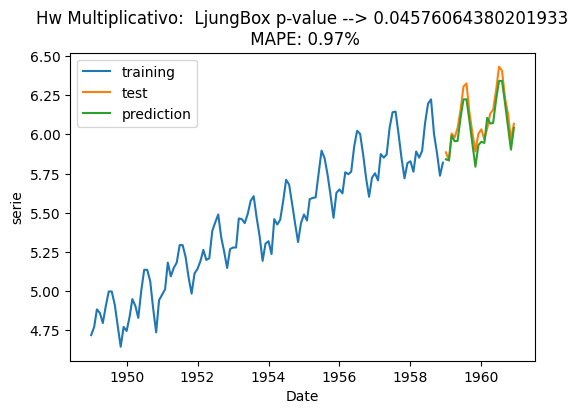

0.04576064380201933


In [35]:
hw_mul = ets.ExponentialSmoothing(Air_tr,trend='add', damped_trend=False, seasonal='mul').fit()
print(hw_mul.summary())

eval_model(hw_mul,Air_tr,Air_tst,'Hw Multiplicativo')


#### Autocorrelaciones con intervalos de confianza

Podemos evaluar los correlogramas de los residuos para este último modelo multiplicativo.


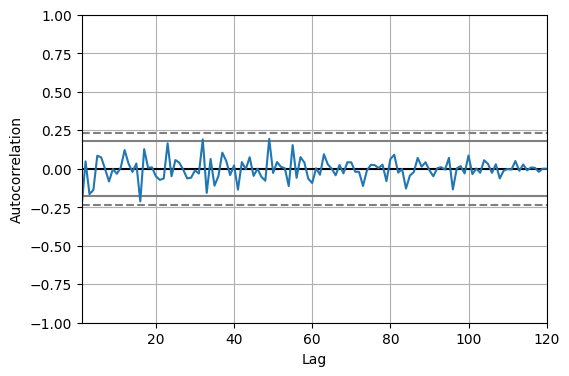

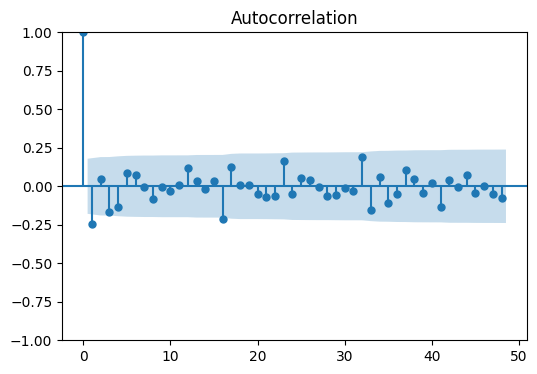

In [36]:
from pandas.plotting import autocorrelation_plot

plt.clf()
autocorrelation_plot(hw_mul.resid)
plt.show()

plot_acf(hw_mul.resid, lags=48)
plt.show()

Y el aditivo?



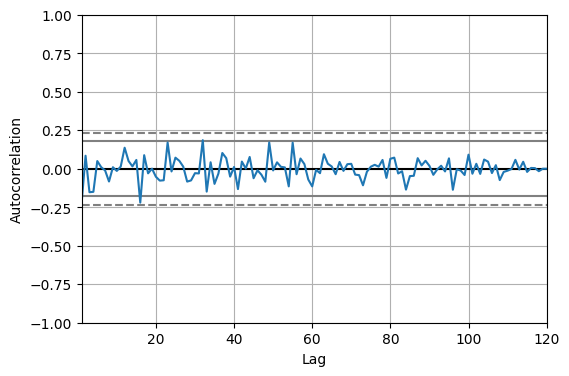

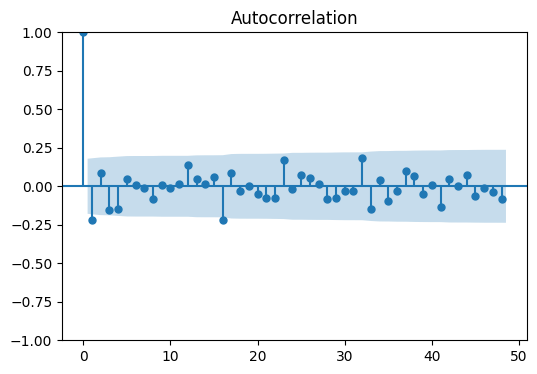

In [37]:
plt.clf()
autocorrelation_plot(hw_add.resid)
plt.show()

plot_acf(hw_add.resid, lags=48)
plt.show()

# Series temporales II. Modelos ARIMA


## Definición de funciones para evaluación

Vamos a reciclar y adeuar las funciones necesarias para facilitarnos la vida en el proceso de ajuste de modelos (arima y en general).

La primera puede funcionar de forma general para cualquier modelo ya que su entrada es el vector de la serie residual..así podremos usarla para culquier filtro de series que apliquemos.

La segunda es una adecuación de la función definida en la parte de suavizado para que pueda funcionar sobre auto_arima (de otro paquete) pues tiene salidas y explotación de modelo distintas. En particular, en auto_arima el *forecast* es *predict* y *resid* es *resid()*


In [38]:
import scipy.stats as stats
import seaborn as sns

# Función para evaluar residuos a través de contrastes de hipótesis
def residcheck(residuals, lags):
    """
    Function to check if the residuals are white noise. Ideally the residuals should be uncorrelated, zero mean, 
    constant variance and normally distributed. First two are must, while last two are good to have. 
    If the first two are not met, we have not fully captured the information from the data for prediction. 
    Consider different model and/or add exogenous variable. 
        
    If Ljung Box test shows p> 0.05, the residuals as a group are white noise. Some lags might still be significant. 
        
    Lags should be min(2*seasonal_period, T/5)
        
    plots from: https://tomaugspurger.github.io/modern-7-timeseries.html
        
    """
    resid_mean = np.mean(residuals)
    lj_p_val = np.mean(sm.stats.acorr_ljungbox(x=residuals, lags=lags).lb_pvalue)
    norm_p_val =  stats.jarque_bera(residuals)[1]
    adfuller_p = adfuller(residuals)[1]
        
      
    fig = plt.figure(figsize=(10,8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2);
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));
    
    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals);
    #[ax.set_xlim(1.5) for ax in [acf_ax, kde_ax]]
    sns.despine()
    plt.tight_layout();
    plt.show()
    print("** Mean of the residuals: ", np.around(resid_mean,2))
        
    print("\n** Ljung Box Test, p-value:", np.around(lj_p_val,3), 
        "(>0.05, Uncorrelated)" if (lj_p_val > 0.05) else "(<0.05, Correlated)")
        
    print("\n** Jarque Bera Normality Test, p_value:", np.around(norm_p_val,3),
        "(>0.05, Normal)" if (norm_p_val>0.05) else "(<0.05, Not-normal)")
        
    print("\n** AD Fuller, p_value:", np.around(adfuller_p,3), 
        "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")
    
    return ts_ax, acf_ax, kde_ax   
 
  


In [39]:
# Función para evaluar modelo auto_arima
def eval_model_Aarima(model,tr,tst,name='Model',lags=12):
      lb = np.mean(sm.stats.acorr_ljungbox(model.resid(), lags=lags, return_df=True).lb_pvalue)
      pred = model.predict(n_periods=len(tst))
      fig1, ax = plt.subplots()
      ax.plot(tr, label='training')
      ax.plot(tst, label='test')
      ax.plot(pred, label='prediction')
      plt.legend(loc='upper left')
      tit = name + ":  LjungBox p-value --> " + str(lb) + "\n MAPE: " + str(round(mean_absolute_percentage_error(tst, pred)*100,2)) + "%"
      plt.title(tit)
      plt.ylabel('Serie')
      plt.xlabel('Date')
      plt.show()
      model.plot_diagnostics(figsize=(14,10))
      plt.show()  


## Arima Manual

Podemos ajustar modelos ARIMA manuales con SARIMAX de statsmodels. Para ello, en primer lugar se deben evaluar las autodcoleraciones para identificar patrones de efectos AR y MA tentativos. Una vez tenemos una idea de los órdenes a proponer, ajustamos los modelos. 

Recordamos correlogramas de la serie logaritmica y doblemente diferenciada. 


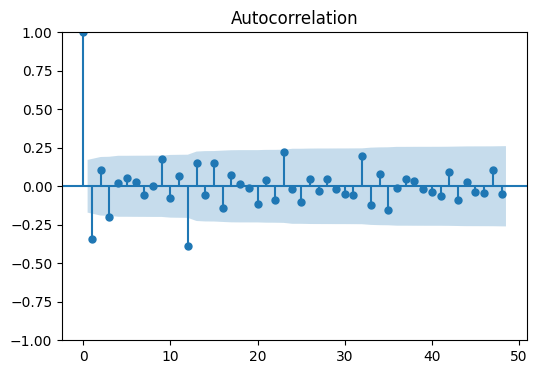

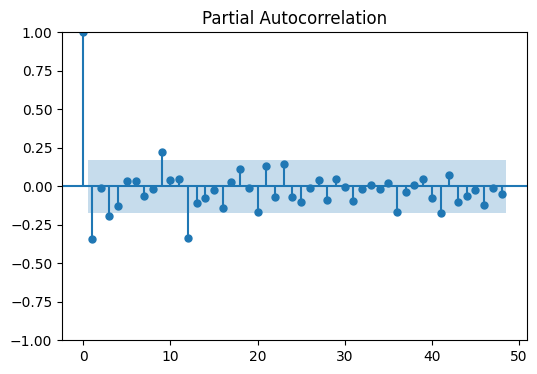

In [40]:
plot_acf(AirLog_diff_1_12.dropna(inplace=False),lags=48)
plt.show()
plot_pacf(AirLog_diff_1_12.dropna(inplace=False),lags=48,method='ywm')
plt.show()


**ACF**: En lo regular, seguro que algo hay. Podría ser un AR si consideramos que hay decrecimiento rápido y no corte en el segundo retardo. Si es así, el órden del AR sería 1 por el corte en el pacf. En lo estacional, el retardo 12 es significativo así que algo debe haber.. No queda muy claro en si parte ar o ma.. 

**PACF**: Parece que hay un corte en el retardo 2, con lo que pensamos en AR, pero luego está ese retardo 3 con descenso..igual es un MA o un enmascaramiento de ambos. En lo estacional, de nuevo el retardo 12 jugando y no queda clara la dinámica de desaparición de las autocorrelaciones estacionales.. 

Con esto probaremos algo así como ARIMA(0-1,1,0-1)(0-1,1,0-1)[12]

**Modelo 1** -> Con ambas partes MA


In [41]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
arima1 = SARIMAX(Air_tr,
                order = (0, 1, 1), 
                seasonal_order =(0, 1, 1, 12))
  
arima_1 = arima1.fit()
arima_1.summary()


C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 197.505
Date:                           mi., 11 dic. 2024   AIC                           -389.010
Time:                                    14:39:27   BIC                           -380.991
Sample:                                01-01-1949   HQIC                          -385.759
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3422      0.087     -3.920      0.000      -0.513      -0.171
ma.S.L12      -0.5406      0.105     -5.156      0.000      -0.746      -0.335
sigma2         0.0014      0.000      7.865      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.94
Prob(Q):                              0.92   Prob(JB):                         0.63
Heteroskedasticity (H):               0.37   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

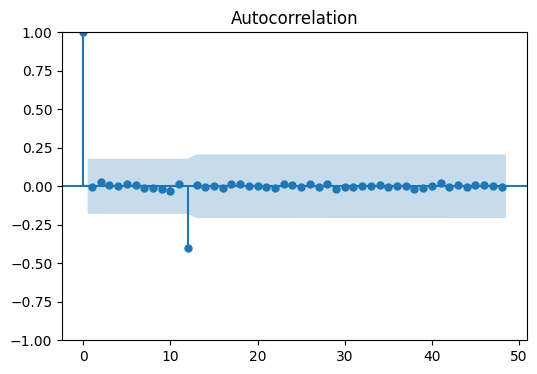

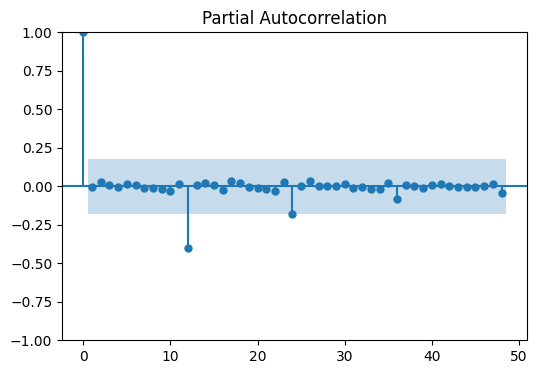

In [42]:
plot_acf(arima_1.resid,lags=48)
plt.show()
plot_pacf(arima_1.resid,lags=48,method='ywm')
plt.show()


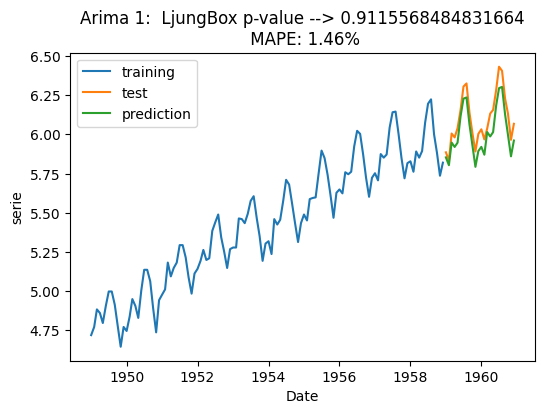

0.9115568484831664


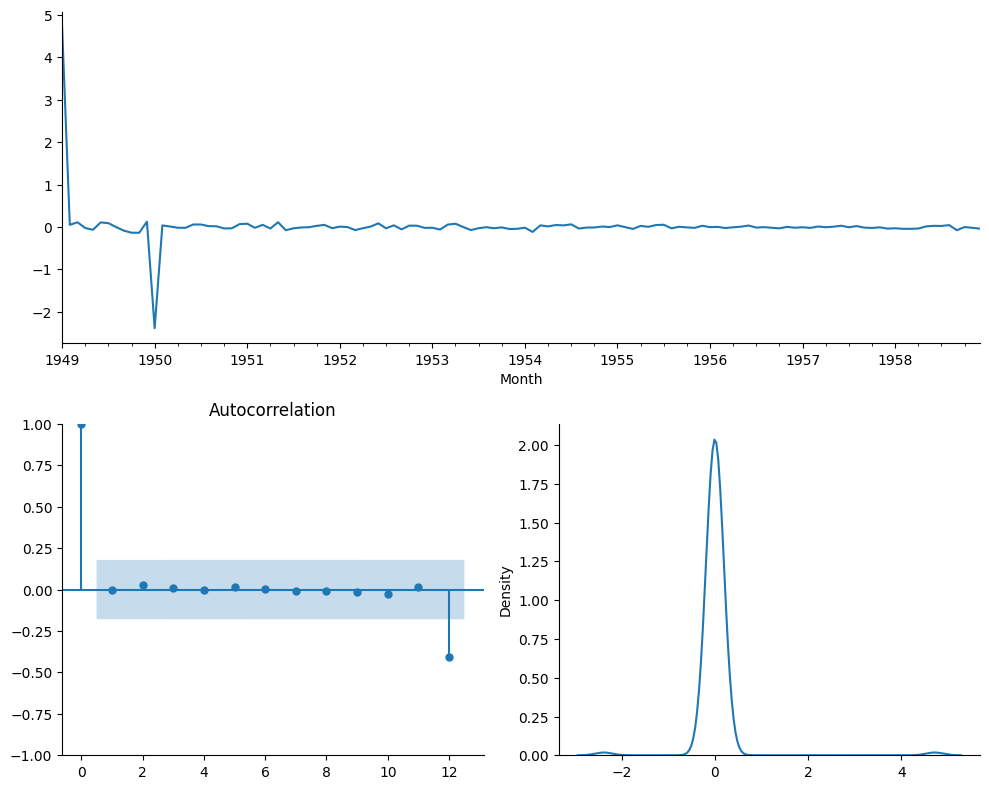

** Mean of the residuals:  0.02

** Ljung Box Test, p-value: 0.912 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<Axes: xlabel='Month'>,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: ylabel='Density'>)

In [43]:
eval_model(arima_1,Air_tr,Air_tst,'Arima 1')

residcheck(arima_1.resid,12)


**Modelo 2** -> Con ambas partes AR



In [44]:
arima2 = SARIMAX(Air_tr, 
                order = (1, 1, 0), 
                seasonal_order =(1, 1, 0, 12))
  
arima_2 = arima2.fit()
arima_2.summary()


C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 194.679
Date:                           mi., 11 dic. 2024   AIC                           -383.359
Time:                                    14:39:29   BIC                           -375.340
Sample:                                01-01-1949   HQIC                          -380.108
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3481      0.079     -4.406      0.000      -0.503      -0.193
ar.S.L12      -0.4428      0.076     -5.811      0.000      -0.592      -0.293
sigma2         0.0015      0.000      7.288      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.70
Prob(Q):                              0.91   Prob(JB):                         0.70
Heteroskedasticity (H):               0.33   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

0.9117938416762911


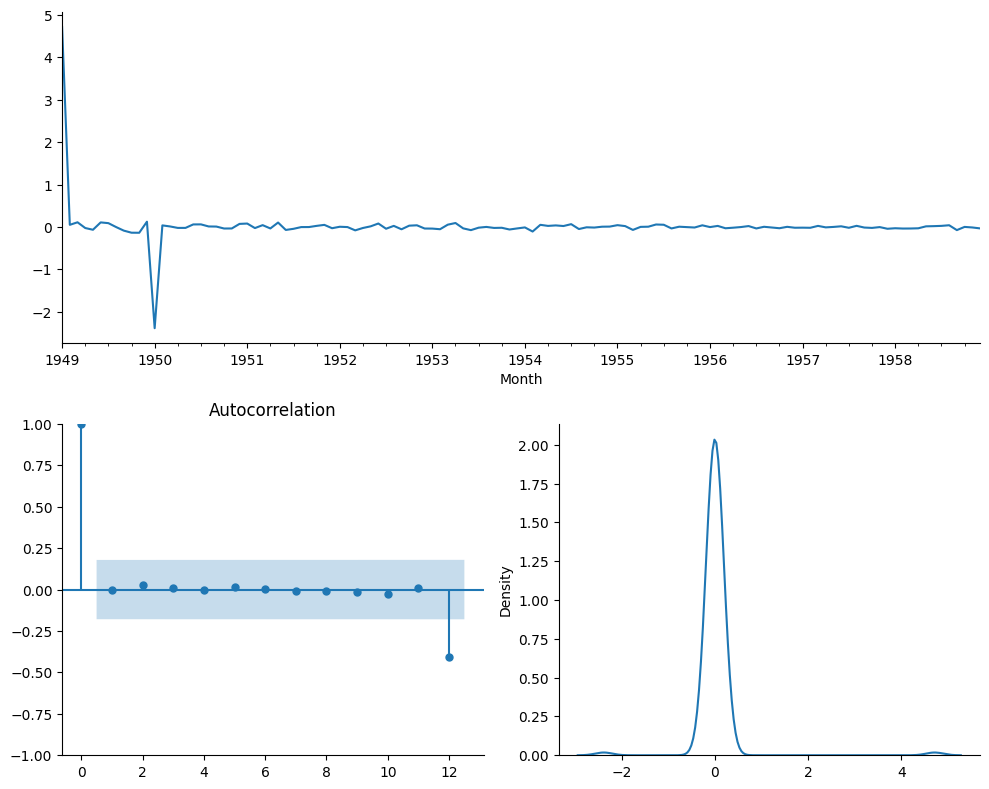

** Mean of the residuals:  0.02

** Ljung Box Test, p-value: 0.912 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<Axes: xlabel='Month'>,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: ylabel='Density'>)

In [45]:
eval_model(arima_2,Air_tr,Air_tst,'Arima 2')

residcheck(arima_2.resid,12)


**Modelo 3** -> Superposición de efectos ARMA en regular y estacional



In [46]:
arima3 = SARIMAX(Air_tr, 
                order = (2, 1, 2), 
                seasonal_order =(2, 0, 2, 12))
  
arima_3 = arima3.fit()
arima_3.summary()


C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 12)   Log Likelihood                 201.236
Date:                           mi., 11 dic. 2024   AIC                           -384.473
Time:                                    14:39:34   BIC                           -359.461
Sample:                                01-01-1949   HQIC                          -374.316
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0573      0.034      1.710      0.087      -0.008       0.123
ar.L2          0.4785      0.094      5.116      0.000       0.295       0.662
ma.L1         -0.3103      0.090     -3.438      0.001      -0.487      -0.133
ma.L2         -0.5160      0.144     -3.588      0.000      -0.798      -0.234
ar.S.L12       0.0226      0.031      0.718      0.473      -0.039       0.084
ar.S.L24       0.9772      0.032     30.743      0.000       0.915       1.039
ma.S.L12       0.0201      0.033      0.612      0.540      -0.044       0.085
ma.S.L24      -0.9314      0.097     -9.591      0.000      -1.122      -0.741
sigma2         0.0013      0.000      6.018      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 4.07
Prob(Q):                              0.80   Prob(JB):                         0.13
Heteroskedasticity (H):               0.87   Skew:                            -0.31
Prob(H) (two-sided):                  0.65   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

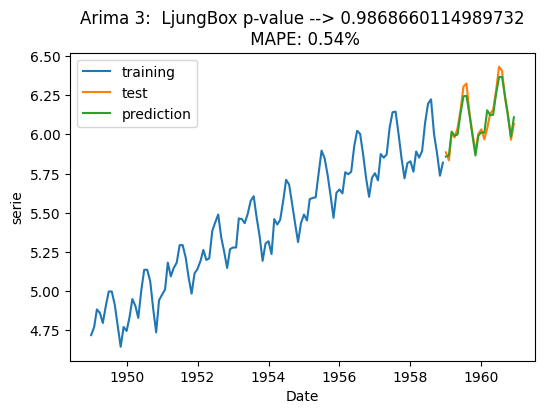

0.9868660114989732


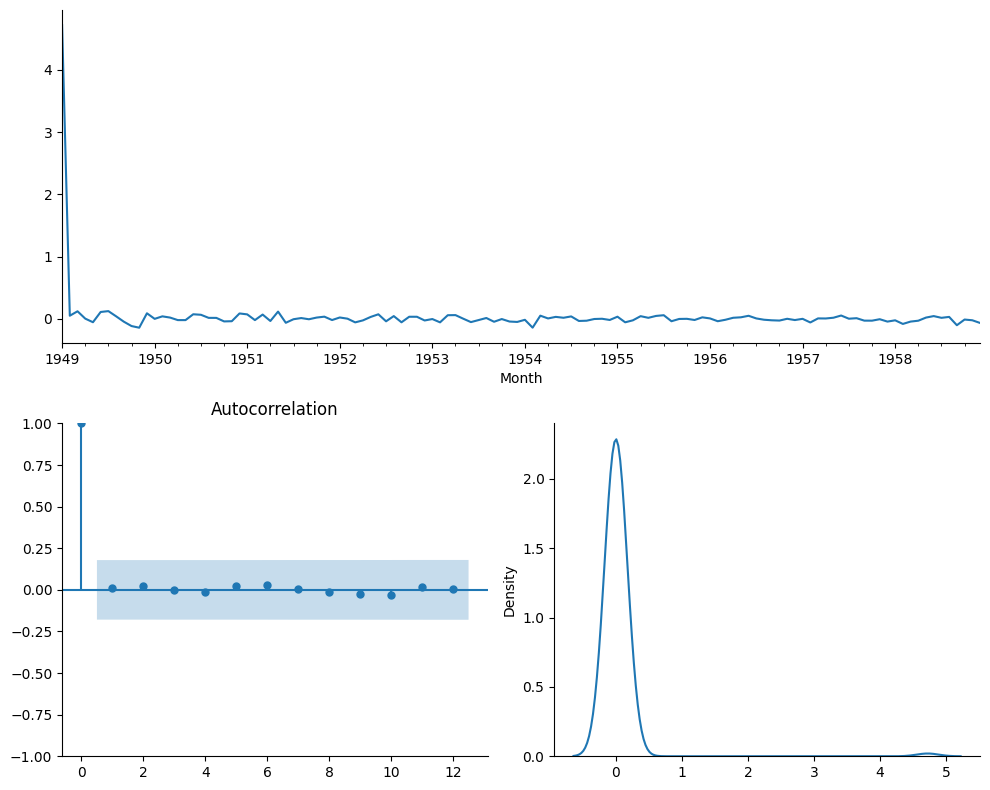

** Mean of the residuals:  0.04

** Ljung Box Test, p-value: 0.987 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<Axes: xlabel='Month'>,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: ylabel='Density'>)

In [47]:
eval_model(arima_3,Air_tr,Air_tst,'Arima 3')
residcheck(arima_3.resid,12)


## Arima automático

En esta parte presentamos la selección de modelos arima mediante AIC que implementa el paquete *pmdarima*. Se puede jugar bastante con órdenes máximos y mínimos para los efectos autoregresivos y de medias móviles, así como con las diferenciaciones regular y estacional. 


Vamos a ajustar el mejor modelo ARIMA automático a la serie clásica de vuelos. 


In [48]:
import pmdarima as pm

# Ajustamos modelo arima step-wise con métrica AIC para la serie de vuelos
arima_auto = pm.auto_arima(Air_tr, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      #start_P=None, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-389.673, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-193.784, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-272.605, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-194.869, Time=0.02 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-270.701, Time=0.30 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-379.294, Time=0.61 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=-398.457, Time=1.82 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=-395.692, Time=1.52 sec
 ARIMA(1,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=2.72 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=-399.124, Time=1.58 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=-304.018, Time=1.45 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=-400.377, Time=1.48 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=-305.012, Time=0.58 sec
 ARIMA(0,1,1)(1,0,1)[12] inte

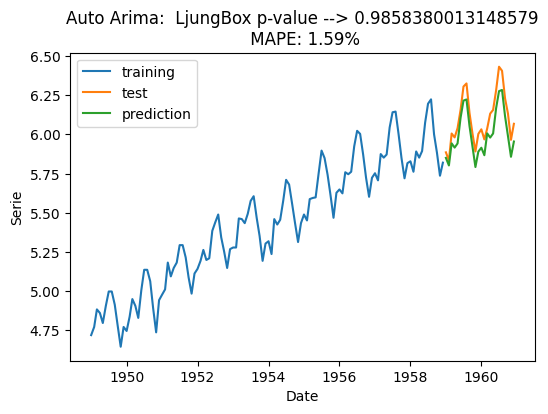

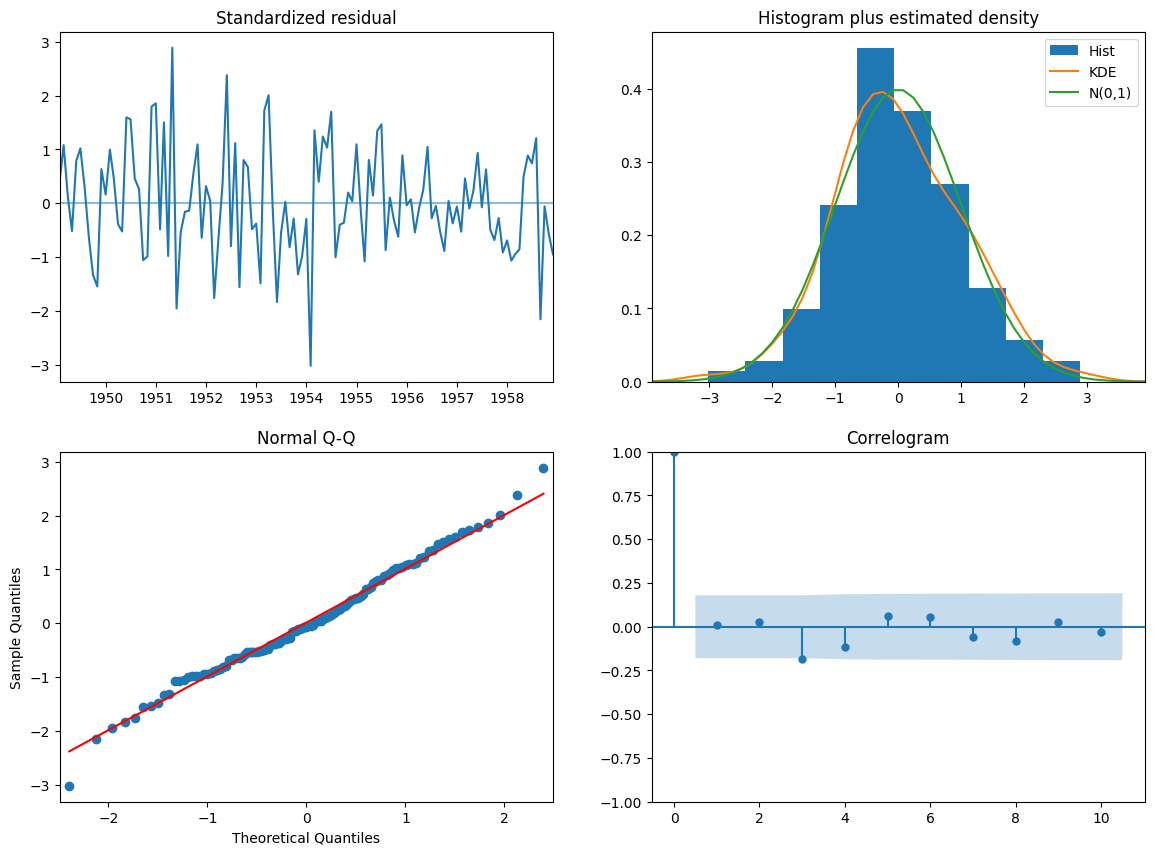

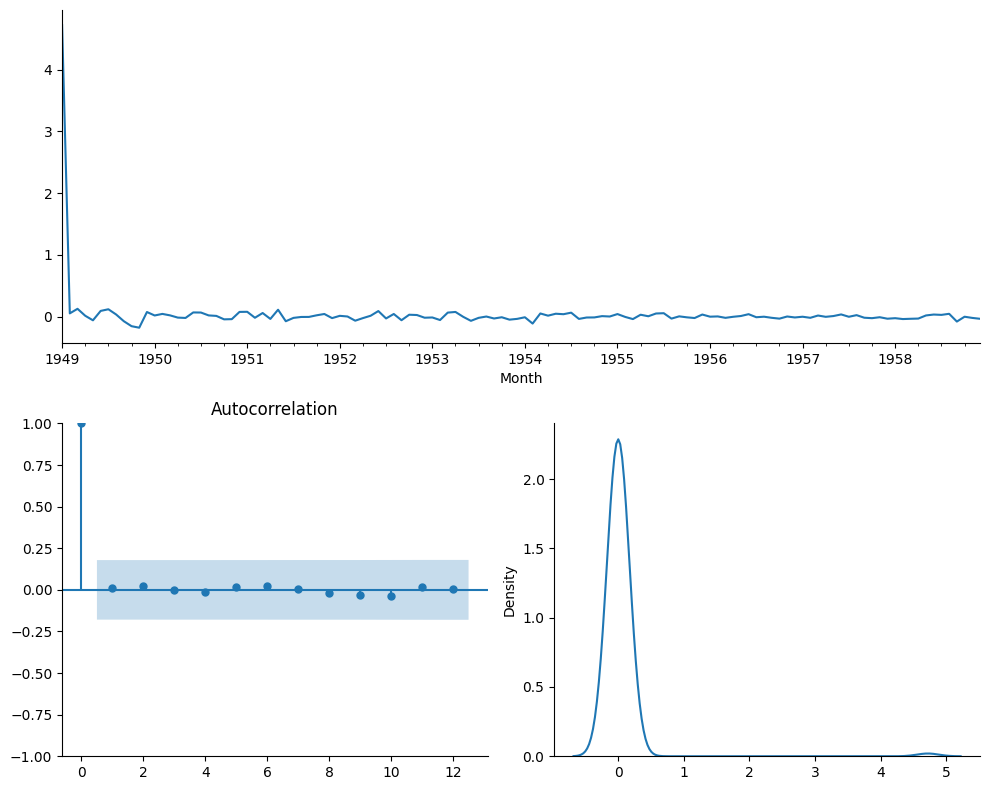

** Mean of the residuals:  0.04

** Ljung Box Test, p-value: 0.986 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<Axes: xlabel='Month'>,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: ylabel='Density'>)

In [49]:
eval_model_Aarima(arima_auto,Air_tr,Air_tst,'Auto Arima')
residcheck(arima_auto.resid(),12)


# Aplicación a Datos sobre viajeros en la ciudad de córdoba 

Ejemplo Cordoba (datos Cordoba.xlsx), donde trataremos de explorar los mejores modelos de suavizado y arima para las dos series que contiene. 


In [50]:
# pip install openpyxl
#Lectura de datos
Cordoba = pd.read_excel('C:\\Users\\Guille\\Documents\\MineriaDatos_2022_23\\Datos\\Cordoba.xlsx')
Cordoba.head()


V_Resident  V_Extranj
0  2005M01       27816       9332
1  2005M02       34920      11387
2  2005M03       45221      21663
3  2005M04       41027      29094
4  2005M05       50750      32076

Cambiamos la M típica del INE por un guion para generar la fecha correctamente. 



In [51]:
Cordoba['Month'] = Cordoba.iloc[:,0].apply(lambda x: x.replace('M','-'))



In [52]:
Cordoba = Cordoba.iloc[:,1:]
Cordoba.head()


V_Resident  V_Extranj    Month
0       27816       9332  2005-01
1       34920      11387  2005-02
2       45221      21663  2005-03
3       41027      29094  2005-04
4       50750      32076  2005-05

Convertir a serie temporal con la fecha indexada.



In [53]:
Cordoba.set_index(['Month'],inplace=True)
Cordoba.index=pd.to_datetime(Cordoba.index)


Veamos.



In [54]:
Cordoba.head()



V_Resident  V_Extranj
Month                            
2005-01-01       27816       9332
2005-02-01       34920      11387
2005-03-01       45221      21663
2005-04-01       41027      29094
2005-05-01       50750      32076

Tenemos la serie de viajeros residentes y la de viajeros extranjeros. Nos preguntamos si se comportan igual en cuanto al turismo en Córdoba. 



In [55]:
Cordoba.V_Resident.plot()
plt.show()


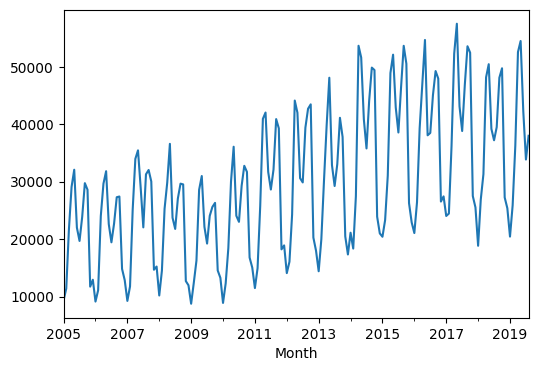

In [56]:
Cordoba.V_Extranj.plot()
plt.show()


Evaluar la estacionariedad de las series al natural.



In [57]:
test_stationarity(Cordoba.V_Extranj)
test_stationarity(Cordoba.V_Resident)


Results of Dickey-Fuller Test:
Test Statistic                  -2.121733
p-value                          0.533907
#Lags Used                      14.000000
Number of Observations Used    161.000000
Critical Value (1%)             -4.016129
Critical Value (5%)             -3.438119
Critical Value (10%)            -3.143266
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -2.200183
p-value                          0.489748
#Lags Used                      12.000000
Number of Observations Used    163.000000
Critical Value (1%)             -4.015411
Critical Value (5%)             -3.437776
Critical Value (10%)            -3.143065
dtype: float64


**Descomposición multiplicativa**



In [58]:
# Aplicar descomposición aditiva
result_E = seasonal_decompose(Cordoba.V_Extranj, model='multiplicative',period=12)
result_E.plot()
plt.show()


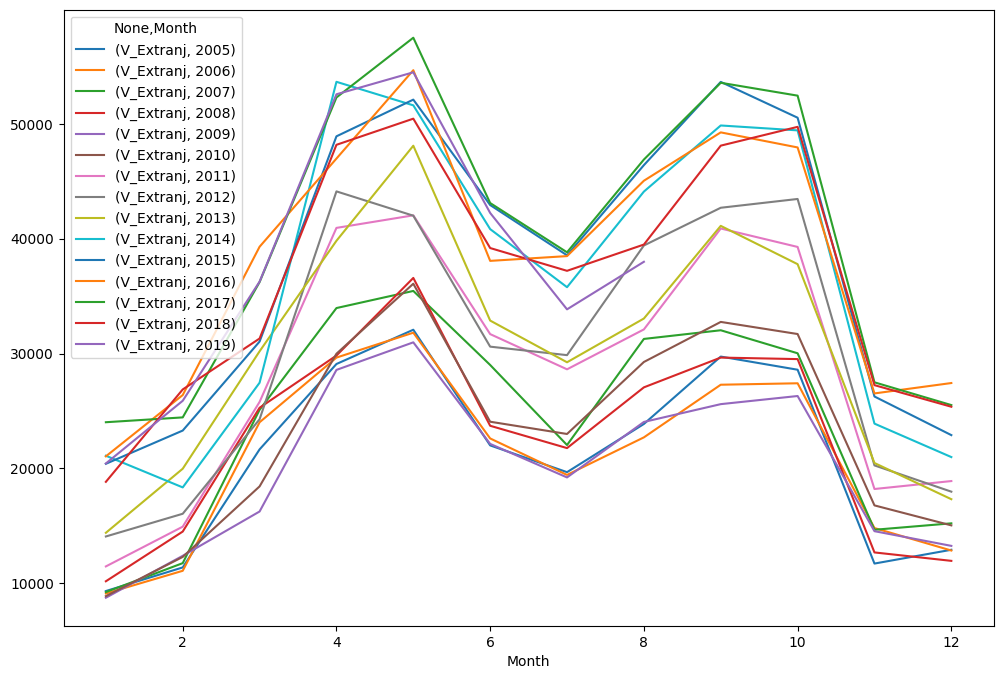

Results of Dickey-Fuller Test:
Test Statistic                -7.290593e+00
p-value                        3.081450e-09
#Lags Used                     9.000000e+00
Number of Observations Used    1.540000e+02
Critical Value (1%)           -4.018792e+00
Critical Value (5%)           -3.439393e+00
Critical Value (10%)          -3.144011e+00
dtype: float64


In [59]:
# Gráfico de estacionalidad
seasonal_plot(Cordoba,column='V_Extranj')
plt.show()

# Test de estacionariedad para los residuos
test_stationarity(result_E.resid.dropna())


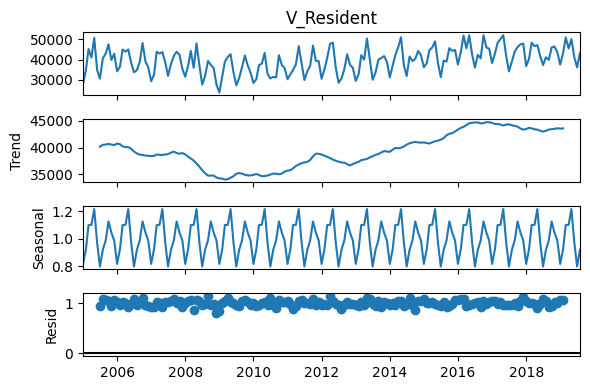

In [60]:
# Aplicar descomposición aditiva
result_R = seasonal_decompose(Cordoba.V_Resident, model='multiplicative',period=12)
result_R.plot()
plt.show()


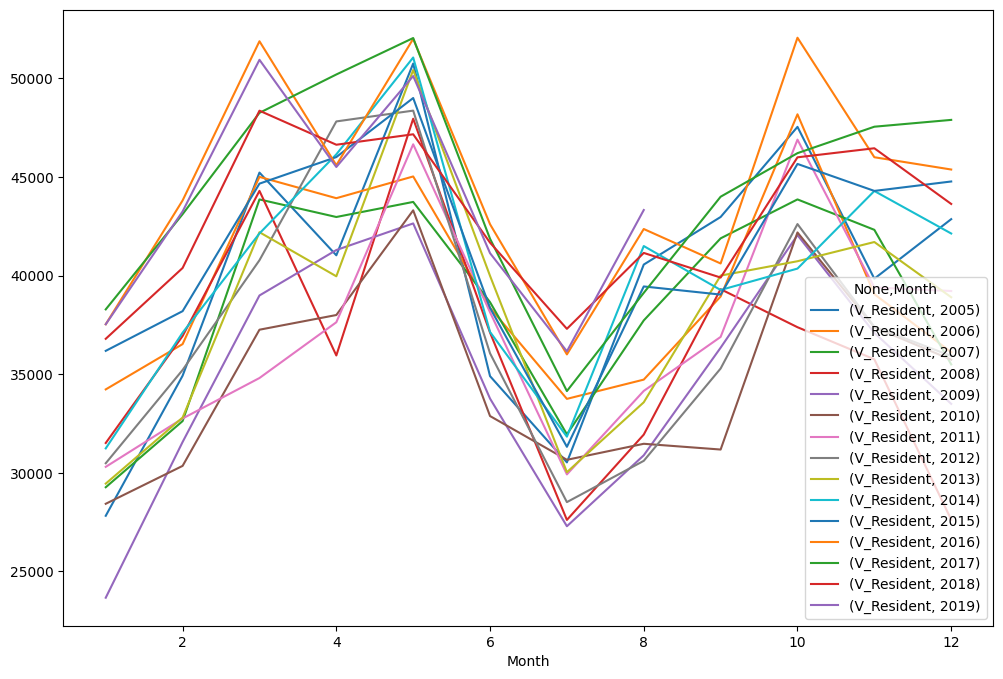

Results of Dickey-Fuller Test:
Test Statistic                -7.386349e+00
p-value                        1.859340e-09
#Lags Used                     9.000000e+00
Number of Observations Used    1.540000e+02
Critical Value (1%)           -4.018792e+00
Critical Value (5%)           -3.439393e+00
Critical Value (10%)          -3.144011e+00
dtype: float64


In [61]:
# Gráfico de estacionalidad
seasonal_plot(Cordoba)
plt.show()

# Test de estacionariedad para los residuos
test_stationarity(result_R.resid.dropna())


Gráficos de aurocorrelación de residuos con bandas de confianza.



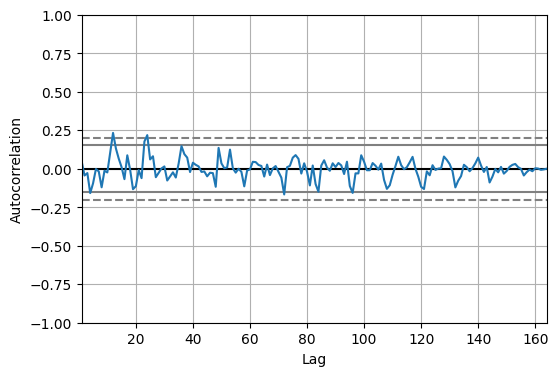

In [62]:
autocorrelation_plot(result_E.resid.dropna())
plt.show()



In [63]:
autocorrelation_plot(result_R.resid.dropna())
plt.show()

Contraste de Ljung-Box para residuos de la descomposición multiplicativa



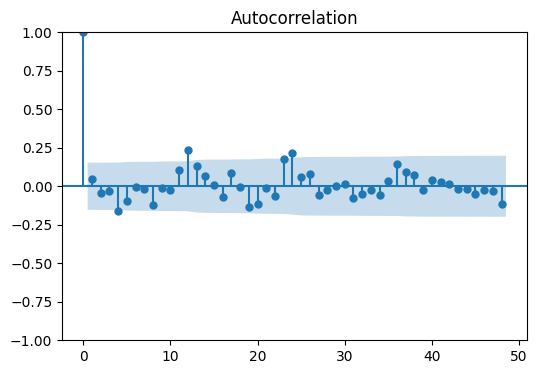

In [64]:
plot_acf(result_E.resid.dropna(),lags=48)
plt.show()

In [65]:
sm.stats.acorr_ljungbox(result_E.resid.dropna(), lags=12, return_df=True)


lb_stat  lb_pvalue
1    0.390086   0.532254
2    0.715787   0.699147
3    0.851541   0.837103
4    5.112490   0.275949
5    6.650613   0.247948
6    6.651175   0.354314
7    6.705458   0.460178
8    9.249181   0.321714
9    9.280102   0.411830
10   9.381525   0.496318
11  11.289299   0.419355
12  20.972195   0.050789

In [66]:
sm.stats.acorr_ljungbox(result_R.resid.dropna(), lags=12, return_df=True)


lb_stat  lb_pvalue
1    2.237791   0.134673
2    8.071325   0.017674
3   11.011894   0.011662
4   14.998395   0.004705
5   20.502372   0.001005
6   21.391819   0.001560
7   21.768829   0.002784
8   21.966624   0.004978
9   24.710894   0.003308
10  26.363710   0.003281
11  29.257182   0.002070
12  32.849279   0.001022

**Partición training-test**



In [67]:
Cordoba_tr = Cordoba[:'2017-12-01']
Cordoba_tst = Cordoba['2018-01-01':]


## Modelos de Suavizado

En esta sección vamos a ajustar modelos de suavizado que parezcar realistas para estas series. Es evidente que nada de simple y doble y nos vamos a Holt Winters. Vamos a probar aditivo y multiplicativo para ambas series.

1. **Extranjeros**

Modelo aditivo.


C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


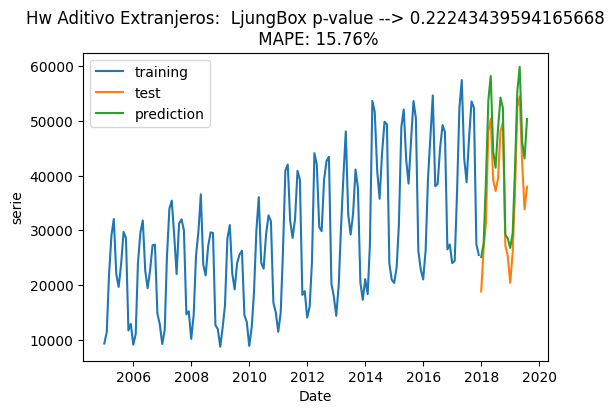

0.22243439594165668


In [68]:
hw_add = ets.ExponentialSmoothing(Cordoba_tr.V_Extranj,trend='add', damped_trend=False, seasonal='add').fit()
eval_model(hw_add,Cordoba_tr.V_Extranj,Cordoba_tst.V_Extranj,'Hw Aditivo Extranjeros')


Modelo multiplicativo. 



In [69]:
hw_mul = ets.ExponentialSmoothing(Cordoba_tr.V_Extranj,trend='mul', damped_trend=False, seasonal='mul').fit()
eval_model(hw_mul,Cordoba_tr.V_Extranj,Cordoba_tst.V_Extranj,'Hw Multiplicativo Extranjeros')


C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


0.4622712999547733


2. **Residentes**

Modelo aditivo.


C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


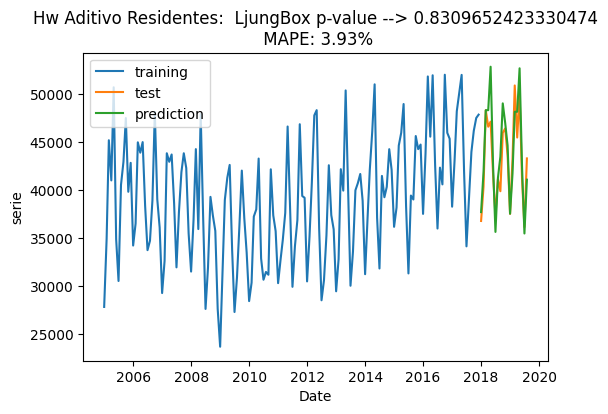

0.8309652423330474


In [70]:
hw_add = ets.ExponentialSmoothing(Cordoba_tr.V_Resident,trend='add', damped_trend=False, seasonal='add').fit()
eval_model(hw_add,Cordoba_tr.V_Resident,Cordoba_tst.V_Resident,'Hw Aditivo Residentes')


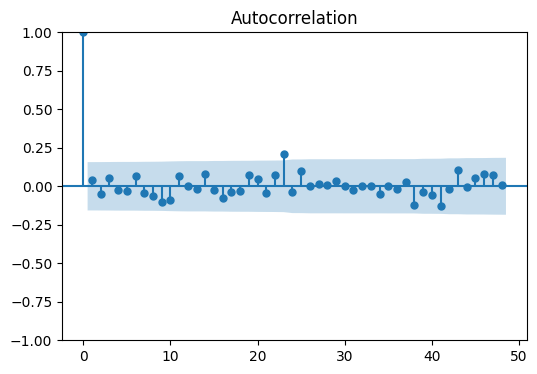

In [71]:

plot_acf(hw_add.resid.dropna(inplace=False),lags=48)
plt.show()

Modelo multiplicativo.



C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


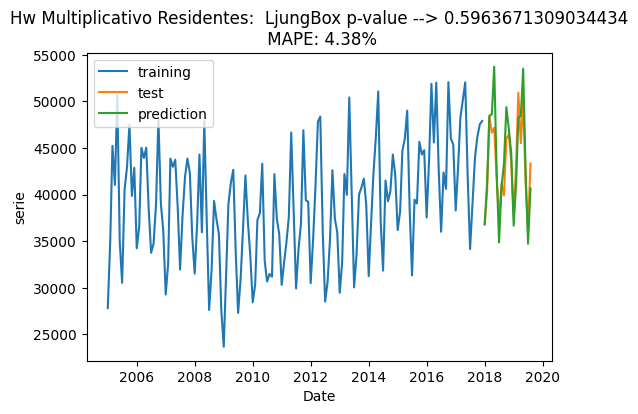

0.5963671309034434


In [72]:
hw_mul = ets.ExponentialSmoothing(Cordoba_tr.V_Resident,trend='mul', damped_trend=False, seasonal='mul').fit()
eval_model(hw_mul,Cordoba_tr.V_Resident,Cordoba_tst.V_Resident,'Hw Multiplicativo Residentes')


## Modelos ARIMA

1. **Extranjeros**

Vistazo a correlogramas.


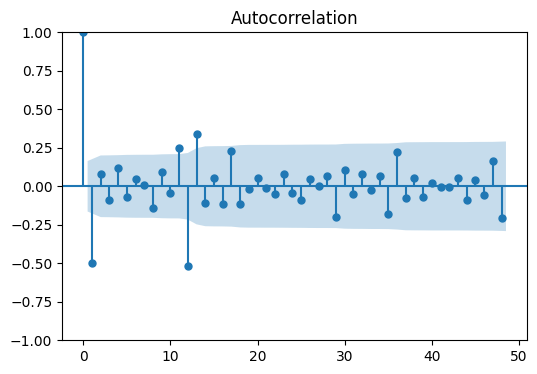

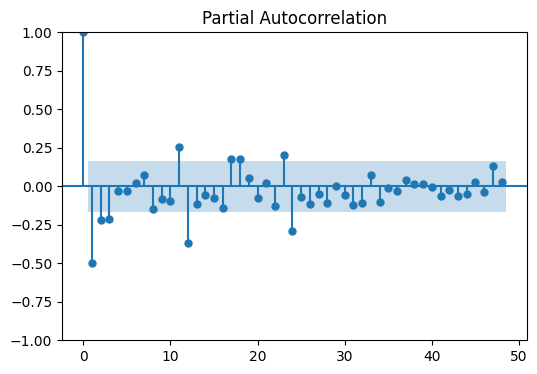

In [73]:
Extranj_diff_1_12 = Cordoba_tr.V_Extranj.diff(periods=1).diff(periods=12)

plot_acf(Extranj_diff_1_12.dropna(inplace=False),lags=48)
plt.show()
plot_pacf(Extranj_diff_1_12.dropna(inplace=False),lags=48,method='ywm')
plt.show()


ACF que se corta en retardo 1, parece Ma 1 en lo regular. También hay corte en retardo 12, huele a MA 1 estacional. 
PACF confirma un poco las sospechas, podríamos decir decrecimiento geométrico en lo regular pero podría haber bajada desde el retardo 1 por lo que podría enmascarar un AR 1.. En lo estacional, decrecimiento, parece MA. 

Asi pues, podemos proponer algo como ARIMA(0-1,1,1)(0,1,1)[12] y jugar un poco por ahí. 


**Arima Manual**


In [74]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
arima1 = SARIMAX(Cordoba_tr.V_Extranj, 
                order = (0, 1, 1), 
                seasonal_order =(0, 1, 1, 12))
  
arima_1 = arima1.fit()
arima_1.summary()


C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          V_Extranj   No. Observations:                  156
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1348.235
Date:                           mi., 11 dic. 2024   AIC                           2702.470
Time:                                    14:40:23   BIC                           2711.359
Sample:                                01-01-2005   HQIC                          2706.082
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5649      0.058     -9.741      0.000      -0.679      -0.451
ma.S.L12      -0.4795      0.065     -7.352      0.000      -0.607      -0.352
sigma2      8.663e+06   7.82e+05     11.085      0.000    7.13e+06    1.02e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                17.18
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                             0.40
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

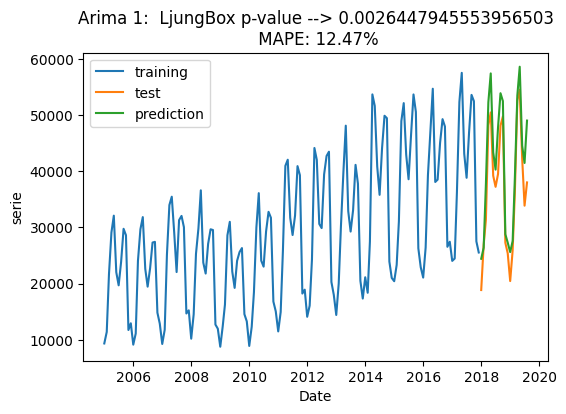

0.0026447945553956503


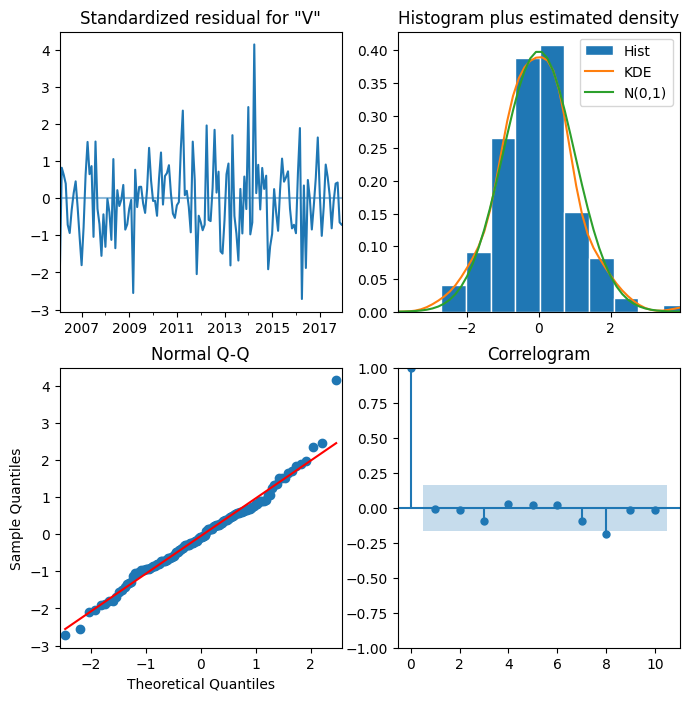

In [75]:
eval_model(arima_1,Cordoba_tr.V_Extranj,Cordoba_tst.V_Extranj,'Arima 1')
arima_1.plot_diagnostics(figsize=(8,8))
plt.show()

In [76]:
arima2 = SARIMAX(Cordoba_tr.V_Extranj, 
                order = (1, 1, 1), 
                seasonal_order =(0, 1, 1, 12))
  
arima_2 = arima2.fit()
arima_2.summary()


C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          V_Extranj   No. Observations:                  156
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1348.099
Date:                           mi., 11 dic. 2024   AIC                           2704.197
Time:                                    14:40:25   BIC                           2716.049
Sample:                                01-01-2005   HQIC                          2709.013
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0793      0.158      0.503      0.615      -0.230       0.389
ma.L1         -0.6163      0.119     -5.182      0.000      -0.849      -0.383
ma.S.L12      -0.4903      0.068     -7.202      0.000      -0.624      -0.357
sigma2      8.643e+06   7.85e+05     11.013      0.000    7.11e+06    1.02e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                18.82
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                             0.40
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

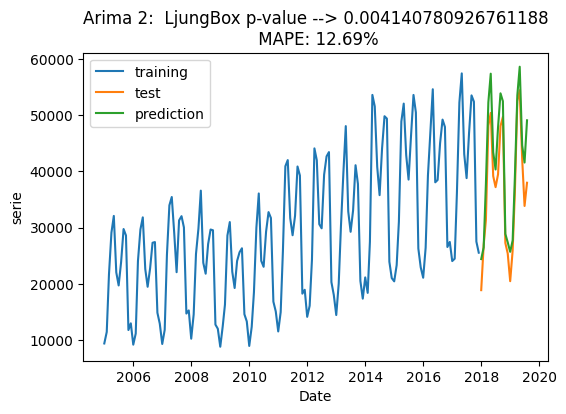

0.004140780926761188


In [77]:
eval_model(arima_2,Cordoba_tr.V_Extranj,Cordoba_tst.V_Extranj,'Arima 2')



Probamos adiferenciar de orden 2 en lo regular.



In [78]:
arima3 = SARIMAX(Cordoba_tr.V_Extranj, 
                order = (1, 2, 2), 
                seasonal_order =(0, 1, 1, 12))
  
arima_3 = arima3.fit()
arima_3.summary()


C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            V_Extranj   No. Observations:                  156
Model:             SARIMAX(1, 2, 2)x(0, 1, [1], 12)   Log Likelihood               -1350.875
Date:                             mi., 11 dic. 2024   AIC                           2711.751
Time:                                      14:40:27   BIC                           2726.530
Sample:                                  01-01-2005   HQIC                          2717.756
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1099      0.196      0.562      0.574      -0.273       0.493
ma.L1         -1.5423      0.192     -8.020      0.000      -1.919      -1.165
ma.L2          0.5433      0.186      2.919      0.004       0.179       0.908
ma.S.L12      -0.5201      0.078     -6.632      0.000      -0.674      -0.366
sigma2      1.013e+07   2.27e-08   4.46e+14      0.000    1.01e+07    1.01e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                10.47
Prob(Q):                              0.58   Prob(JB):                         0.01
Heteroskedasticity (H):               1.01   Skew:                             0.32
Prob(H) (two-sided):                  0.96   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.29e+30. Standard errors may be unstable.
"""

In [79]:
eval_model(arima_3,Cordoba_tr.V_Extranj,Cordoba_tst.V_Extranj,'Arima 3')



0.1863186361643698


Auto ARIMA 

Vamos a aplicar automatismos para buscar los mejores órdenes en relación al AIC utilizando auro_arima.


In [80]:
# Auto arima
arima_auto = pm.auto_arima(Cordoba_tr.V_Extranj, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      #start_P=None, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,1,1)[12]             : AIC=inf, Time=1.15 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=2924.228, Time=0.05 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=2807.137, Time=0.16 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=2837.587, Time=0.07 sec
 ARIMA(1,2,0)(2,1,0)[12]             : AIC=2799.067, Time=0.38 sec
 ARIMA(1,2,0)(2,1,1)[12]             : AIC=2800.645, Time=0.71 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=2794.444, Time=0.40 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=2799.773, Time=0.13 sec
 ARIMA(1,2,0)(1,1,2)[12]             : AIC=inf, Time=1.75 sec
 ARIMA(1,2,0)(0,1,2)[12]             : AIC=2793.990, Time=0.91 sec
 ARIMA(0,2,0)(0,1,2)[12]             : AIC=2859.093, Time=0.60 sec
 ARIMA(2,2,0)(0,1,2)[12]             : AIC=2770.998, Time=1.19 sec
 ARIMA(2,2,0)(0,1,1)[12]             : AIC=2775.698, Time=0.18 sec
 ARIMA(2,2,0)(1,1,2)[12]          

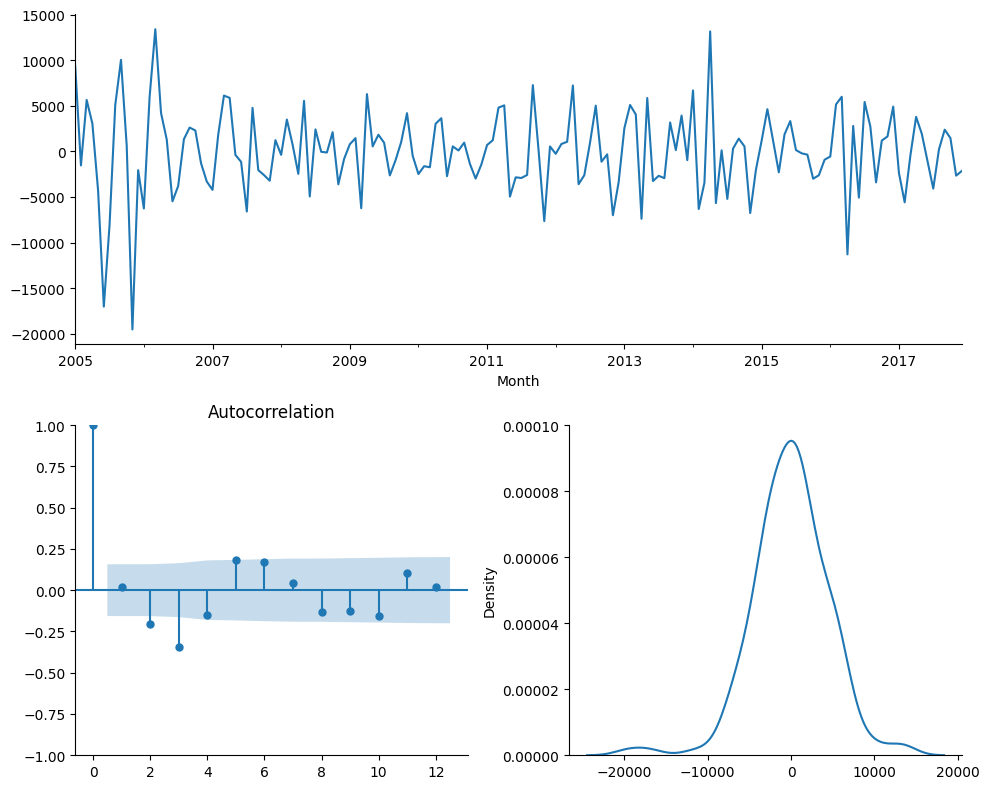

** Mean of the residuals:  -35.67

** Ljung Box Test, p-value: 0.068 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<Axes: xlabel='Month'>,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: ylabel='Density'>)

In [81]:
residcheck(arima_auto.resid(),12)



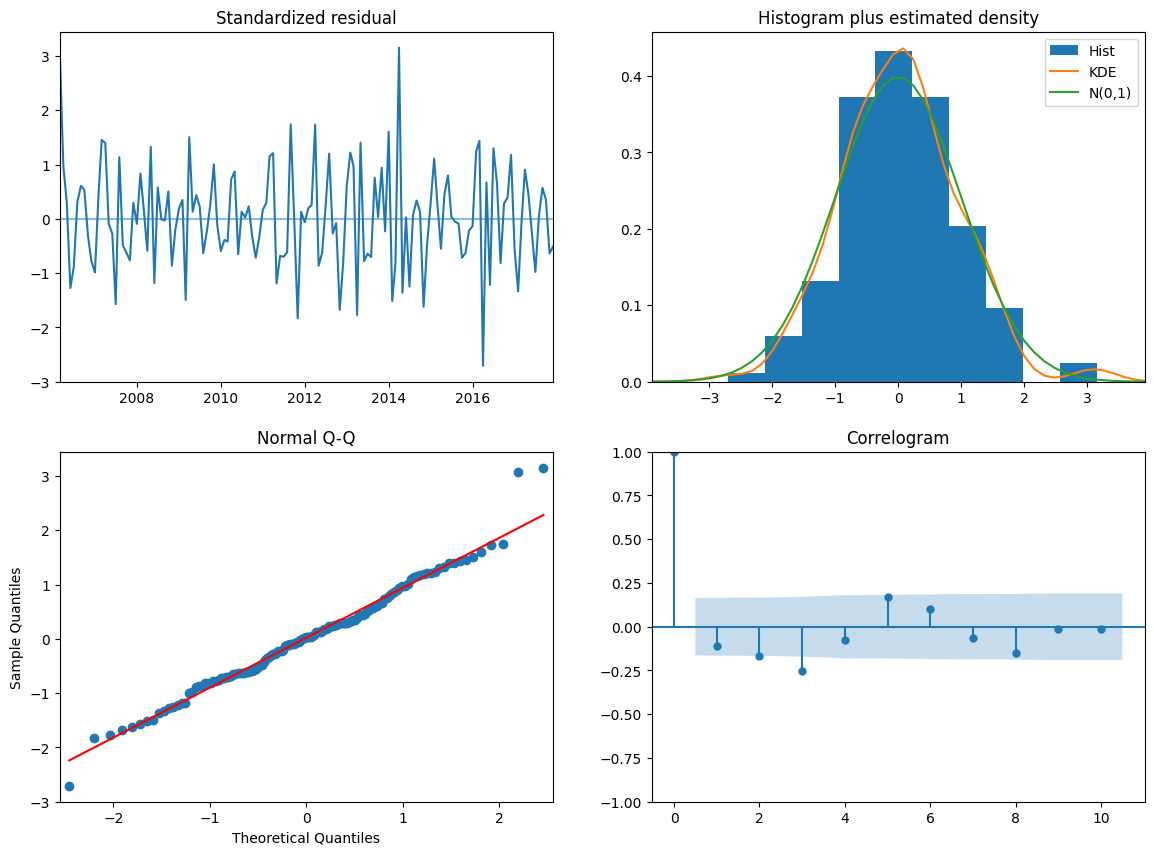

In [82]:
eval_model_Aarima(arima_auto,Cordoba_tr.V_Extranj,Cordoba_tst.V_Extranj,'Auto Arima')



2. **Residentes**

Vistazo a correlogramas.


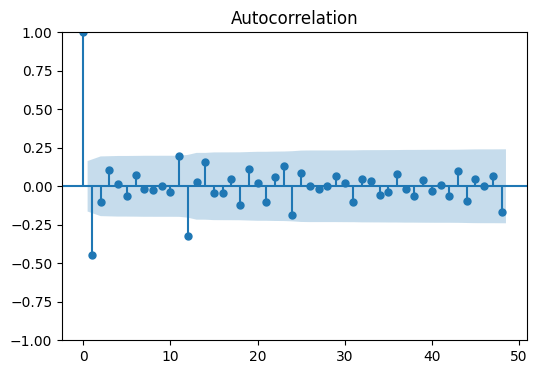

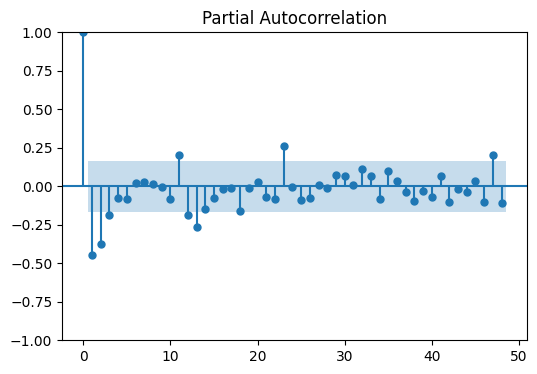

In [83]:
Resid_diff_1= Cordoba_tr.V_Resident.diff(periods=1)#.diff(periods=12)

plot_acf(Resid_diff_1.diff(periods=12).dropna(inplace=False),lags=48)
plt.show()
plot_pacf(Resid_diff_1.diff(periods=12).dropna(inplace=False),lags=48,method='ywm')
plt.show()


Parte AR de orden 2 enmascarada por parte MA de orden 1 en lo regular. 

Parte AR de orden 1-2 enmascarada por algo de MA seguramente en lo estacional

Por esto nuestros candidatos a ajustar serían: ARIMA(2,1,1)(1-2,1,0-1-2)[12], o cualquiera de sus variaciones en las porsiciones autoregresivas o de medias móviles.

**Arima Manual**


In [84]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
arima1 = SARIMAX(Cordoba_tr.V_Resident, 
                order = (2, 1, 1), 
                seasonal_order =(1, 1, 0, 12))
  
arima_1 = arima1.fit()
arima_1.summary()


C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          V_Resident   No. Observations:                  156
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1375.799
Date:                            mi., 11 dic. 2024   AIC                           2761.598
Time:                                     14:40:42   BIC                           2776.412
Sample:                                 01-01-2005   HQIC                          2767.617
                                      - 12-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2956      0.474     -0.623      0.533      -1.225       0.634
ar.L2         -0.1721      0.165     -1.042      0.297      -0.496       0.152
ma.L1         -0.0796      0.465     -0.171      0.864      -0.991       0.831
ar.S.L12      -0.3116      0.032     -9.781      0.000      -0.374      -0.249
sigma2       1.17e+07   3.79e-08   3.09e+14      0.000    1.17e+07    1.17e+07
===================================================================================
Ljung-Box (L1) (Q):                   4.22   Jarque-Bera (JB):                 2.09
Prob(Q):                              0.04   Prob(JB):                         0.35
Heteroskedasticity (H):               0.52   Skew:                            -0.25
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.31e+30. Standard errors may be unstable.
"""

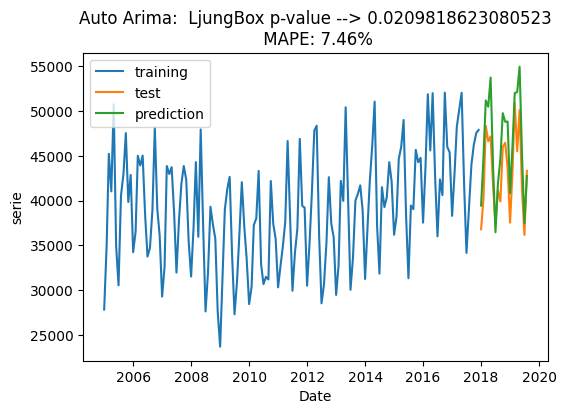

0.0209818623080523


In [85]:
eval_model(arima_1,Cordoba_tr.V_Resident,Cordoba_tst.V_Resident,'Auto Arima')



In [86]:
arima2 = SARIMAX(Cordoba_tr.V_Resident, 
                order = (0, 1, 1), 
                seasonal_order =(2, 1, 0, 12))
  
arima_2 = arima2.fit()
arima_2.summary()


C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          V_Resident   No. Observations:                  156
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood               -1367.472
Date:                            mi., 11 dic. 2024   AIC                           2742.944
Time:                                     14:40:43   BIC                           2754.796
Sample:                                 01-01-2005   HQIC                          2747.760
                                      - 12-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3379      0.039     -8.682      0.000      -0.414      -0.262
ar.S.L12      -0.4427      0.044    -10.019      0.000      -0.529      -0.356
ar.S.L24      -0.2632      0.046     -5.740      0.000      -0.353      -0.173
sigma2      1.197e+07   4.61e-10    2.6e+16      0.000     1.2e+07     1.2e+07
===================================================================================
Ljung-Box (L1) (Q):                   3.13   Jarque-Bera (JB):                 1.28
Prob(Q):                              0.08   Prob(JB):                         0.53
Heteroskedasticity (H):               0.57   Skew:                            -0.22
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.85e+31. Standard errors may be unstable.
"""

In [87]:
eval_model(arima_2,Cordoba_tr.V_Resident,Cordoba_tst.V_Resident,'Auto Arima')



0.06053505723173828


In [88]:
sm.stats.acorr_ljungbox(arima_2.resid.dropna(), lags=12, return_df=True)

lb_stat  lb_pvalue
1    4.776154   0.028857
2    5.996332   0.049878
3    6.226136   0.101112
4    6.454726   0.167665
5    8.982099   0.109780
6   10.512834   0.104651
7   16.433446   0.021438
8   16.434450   0.036567
9   16.846207   0.051180
10  21.124533   0.020242
11  21.235024   0.031016
12  28.931306   0.004034

In [89]:
arima3 = SARIMAX(Cordoba_tr.V_Resident, 
                order = (0, 1, 1), 
                seasonal_order =(1, 0, 1 ,12))
  
arima_3 = arima3.fit()
arima_3.summary()


C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Guille\anaconda3\envs\Mineria\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         V_Resident   No. Observations:                  156
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1511.087
Date:                           mi., 11 dic. 2024   AIC                           3030.175
Time:                                    14:40:43   BIC                           3042.349
Sample:                                01-01-2005   HQIC                          3035.120
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5129      0.040    -12.892      0.000      -0.591      -0.435
ar.S.L12       0.9732      0.018     53.125      0.000       0.937       1.009
ma.S.L12      -0.7487      0.079     -9.495      0.000      -0.903      -0.594
sigma2      1.535e+07   3.48e-09   4.41e+15      0.000    1.53e+07    1.53e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.27   Jarque-Bera (JB):                47.31
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.8e+30. Standard errors may be unstable.
"""

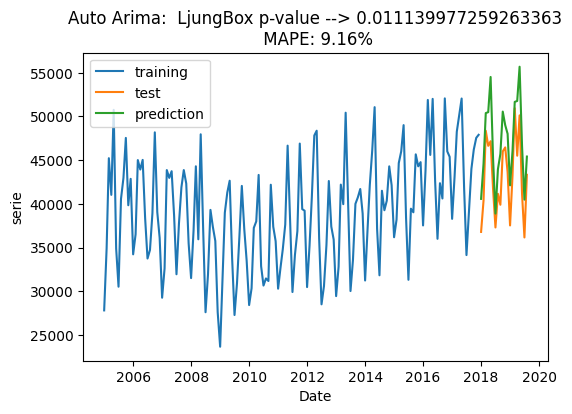

0.011139977259263363


In [90]:
eval_model(arima_3,Cordoba_tr.V_Resident,Cordoba_tst.V_Resident,'Auto Arima')



Auto ARIMA 

Vamos a aplicar automatismos para buscar los mejores órdenes en relación al AIC utilizando auro_arima.


In [91]:
Cordoba_tr.V_Resident.shape

(156,)

In [92]:
# Auto arima
arima_auto = pm.auto_arima(Cordoba_tr.V_Resident, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      #start_P=None, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3156.226, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3065.344, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3109.121, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3154.295, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3158.127, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3056.735, Time=0.51 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3066.765, Time=0.48 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3037.643, Time=0.36 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3099.284, Time=0.17 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3069.925, Time=0.84 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3107.161, Time=0.15 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3043.853, Time=0.33 sec
 ARIMA(2,1,0)(1,0,1)[12] inte

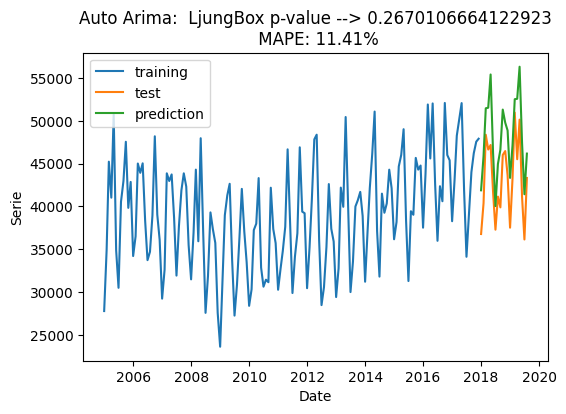

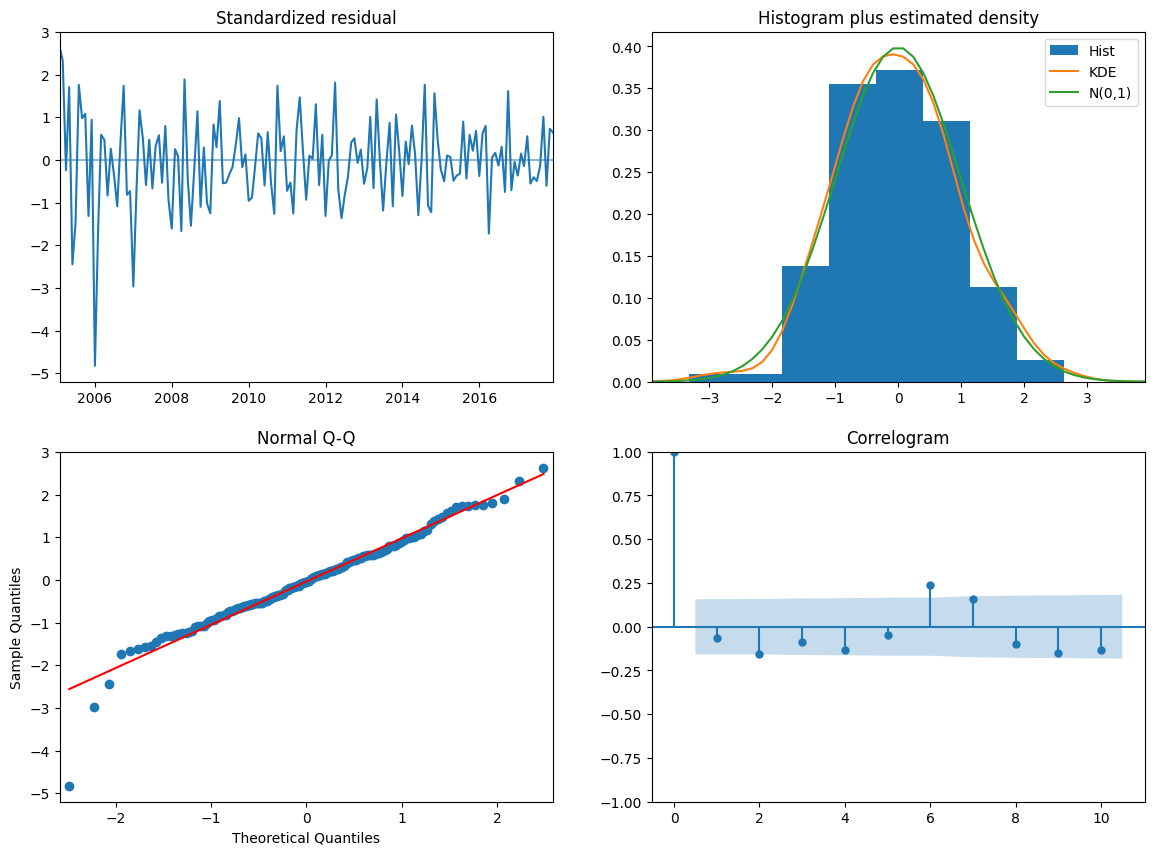

In [93]:
#residcheck(arima_auto.resid(),12)
eval_model_Aarima(arima_auto,Cordoba_tr.V_Resident,Cordoba_tst.V_Resident,'Auto Arima')


In [94]:
sm.stats.acorr_ljungbox(arima_auto.resid(), lags=12, return_df=True)

lb_stat  lb_pvalue
1    0.649617   0.420250
2    0.694962   0.706465
3    1.824129   0.609698
4    2.333949   0.674595
5    5.180260   0.394280
6    8.166206   0.226178
7   16.595781   0.020197
8   16.891344   0.031261
9   17.794068   0.037639
10  21.428622   0.018295
11  21.722810   0.026611
12  21.899731   0.038659

In [95]:
arima_auto.resid()

Month
2005-01-01    28145.998738
2005-02-01    14071.149323
2005-03-01    12441.825154
2005-04-01    -1274.369995
2005-05-01     9111.599497
                  ...     
2017-08-01     -559.894133
2017-09-01     4056.665006
2017-10-01    -2426.646380
2017-11-01     2935.069583
2017-12-01     2578.822670
Length: 156, dtype: float64